# Multiple Classifiers

Predict the the following attributes from a pubmed abstract of a clinical trial:

- intervention_model
- primary_purpose
- gender
- healthy_volunteers

In [5]:
%store -r abstracts_targets

df = abstracts_targets

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2093 entries, 0 to 2126
Data columns (total 14 columns):
abstract                   2086 non-null object
pmid                       2086 non-null object
allocation                 1740 non-null object
endpoint_classification    1876 non-null object
intervention_model         2078 non-null object
masking                    2085 non-null object
primary_purpose            2008 non-null object
condition                  2086 non-null object
gender                     2086 non-null object
healthy_volunteers         2085 non-null object
maximum_age                2086 non-null object
minimum_age                2086 non-null object
phase                      2086 non-null object
study_type                 2086 non-null object
dtypes: object(14)
memory usage: 245.3+ KB


### Word Cloud

In [6]:
import wordcloud

def word_cloud(words, axes, title):
    wc = wordcloud.WordCloud().generate(words)
    axes.imshow(wc)
    axes.axis('off')
    plt.title(title)

### Fit and Transform

In [17]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()

def train_and_go(df, target):
    """Training and Plotting
    
    - Filter away abstracts which don't have a label for the target
    - Vectorize the remaining abstracts
    - Train/test split
    - Train model
    - Predict
    - Confusion matrix
    - Features with highest coefficients
    
    """
    # Filter away abstracts which don't have a label for the target
    df = df[df[target].notnull()]

    # Vectorize remaining abstracts
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df.abstract)
    
    # Extract vocabulary and order it
    import operator
    vocabulary = [word for word, index in sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))]
    
    # Train Test Split
    from sklearn.cross_validation import train_test_split
    X_train, X_test, ys_train, ys_test = train_test_split(X, df[target])
    X_train.shape, X_test.shape, ys_train.shape, ys_test.shape
    
    # Train model
    from sklearn import linear_model
    logreg = linear_model.LogisticRegression(C=1e5, class_weight='balanced', multi_class='multinomial', solver='lbfgs')
    logreg.fit(X_train, ys_train)

    # Prediction
    import sklearn
    predictions = logreg.predict(X_test)
    labels = logreg.classes_
    print '{} classes: {}'.format(target, labels)
    print '{} f1: {}'.format(target, sklearn.metrics.f1_score(lb.fit_transform(ys_test), lb.fit_transform(predictions), average=None))

    # Confusion Matrix
    confusion_matrix = sklearn.metrics.confusion_matrix(ys_test, predictions)
    fig = plt.figure()
    plt.clf()
    plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
    plt.title('Confusion Matrix')
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    width = height = len(labels)
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(confusion_matrix[x][y]) if confusion_matrix[x][y] else '', xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')

    # Features with Highest Coefficients
    fig = plt.figure(figsize=(20, 20))
    plt.clf()
    for i, (weights, title) in enumerate(zip(logreg.coef_, labels), start=1):
        words = sorted(zip(weights, vocabulary), reverse=True)[:10]
        words = ' '.join(word[1] for word in words)

        axes = fig.add_subplot(4, 2, i)
        word_cloud(words, axes, title)

    plt.axis('off')
    plt.show()

### Train Classifiers

Note the size of the words in the word clouds below are **not** to be trusted!

healthy_volunteers classes: ['Accepts Healthy Volunteers' 'No']
healthy_volunteers f1: [ 0.55737705  0.90592334]


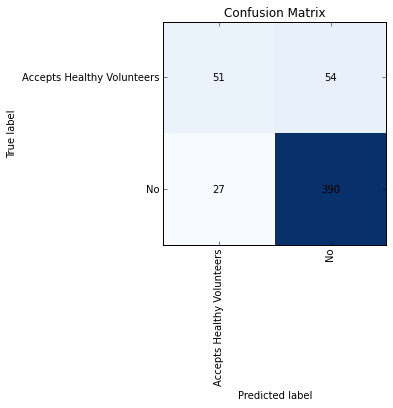

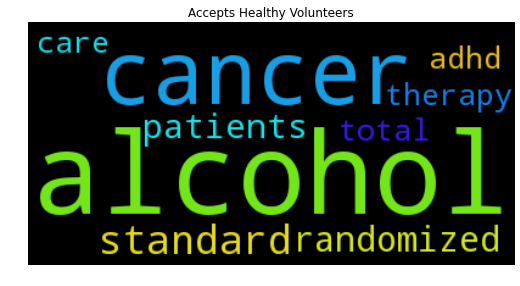

gender classes: ['Both' 'Female' 'Male']
gender f1: [ 0.96447793  0.73333333  0.64      ]


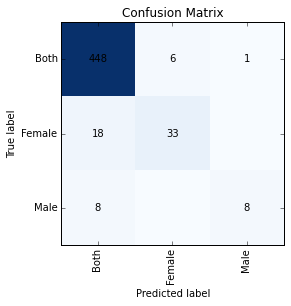

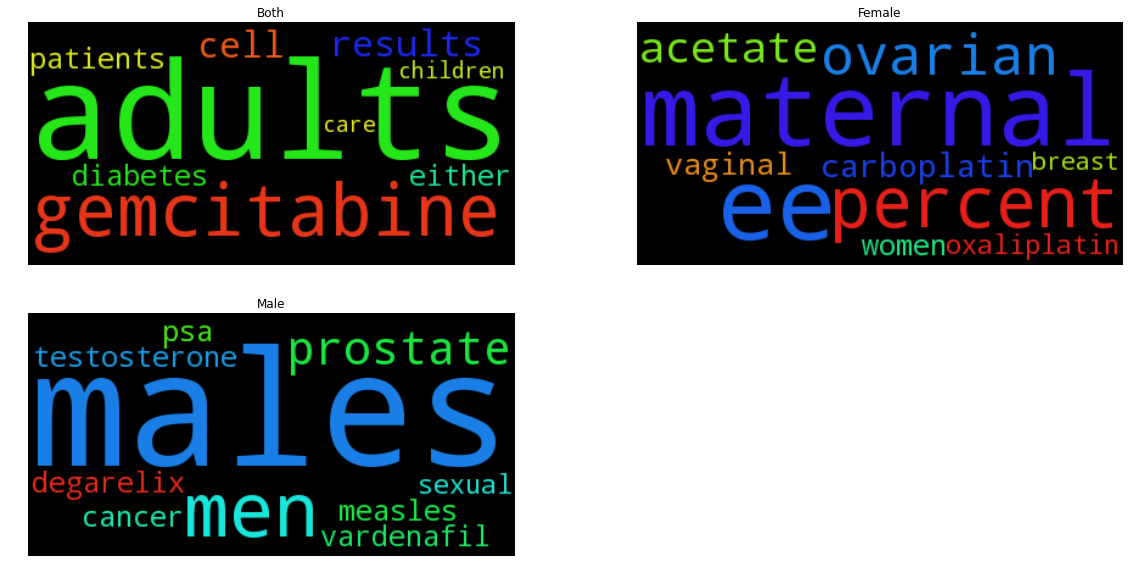

primary_purpose classes: ['Basic Science' 'Diagnostic' 'Health Services Research' 'Prevention'
 'Supportive Care' 'Treatment']
primary_purpose f1: [ 0.15384615  0.35294118  0.33333333  0.58490566  0.26666667  0.91257485]


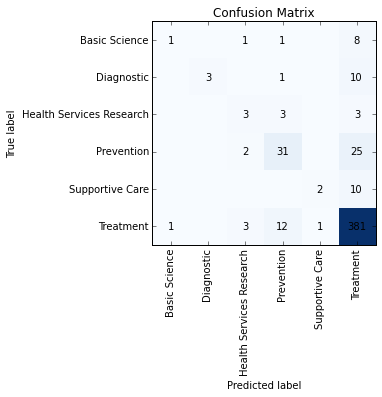

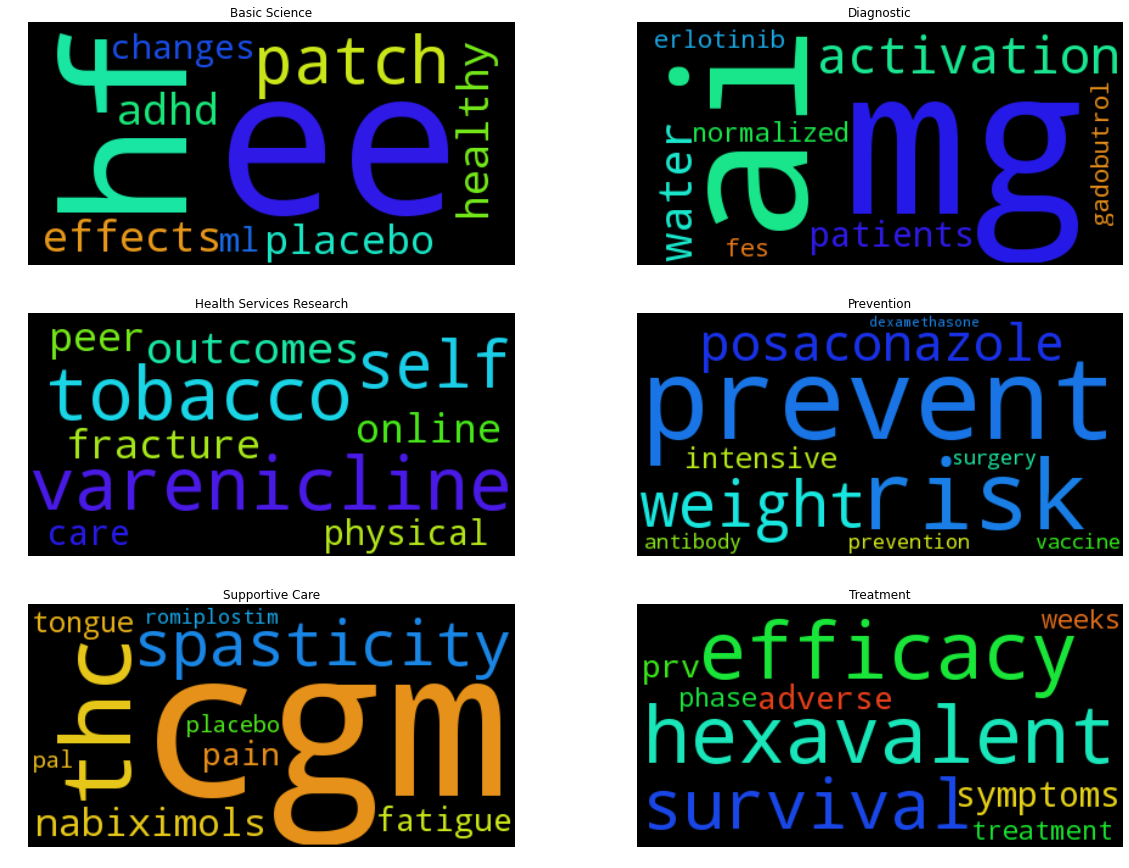

intervention_model classes: ['Crossover Assignment' 'Factorial Assignment' 'Parallel Assignment'
 'Single Group Assignment']
intervention_model f1: [ 0.43835616  0.          0.8356546   0.69230769]


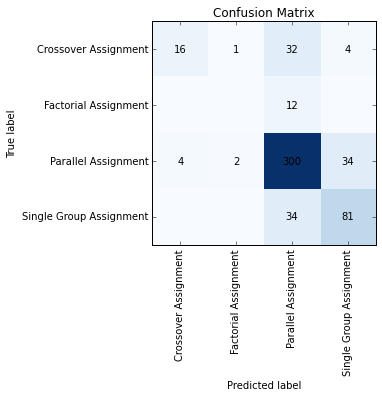

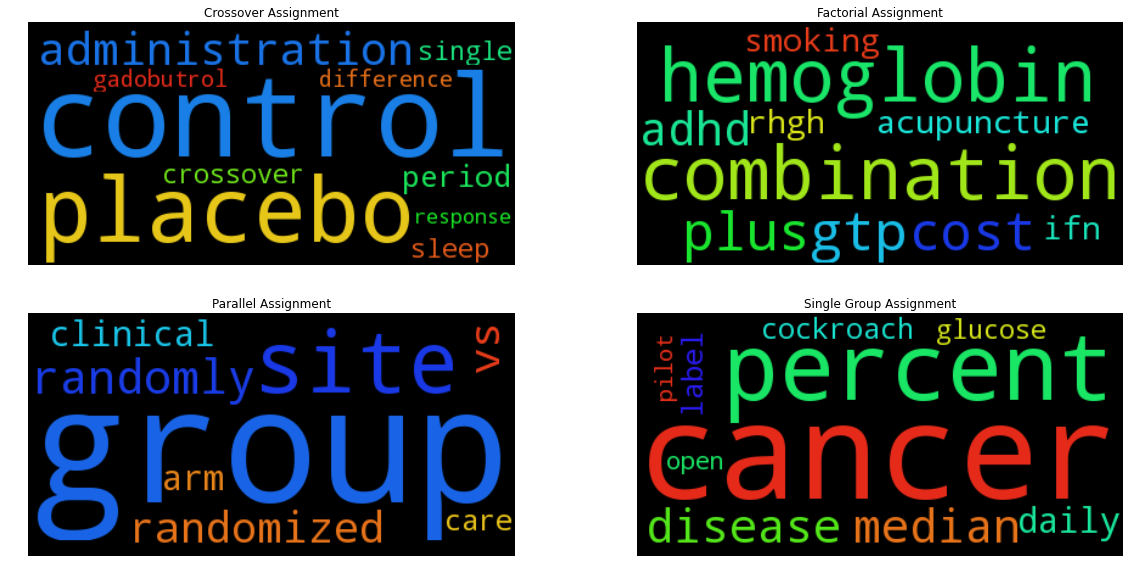

In [18]:
df[df.primary_purpose == 'Screening'] = None # this class is causing us all sorts of trouble

for target in ('healthy_volunteers', 'gender', 'primary_purpose', 'intervention_model'):
    train_and_go(df, target)